Task 3: Customer Segmentation / Clustering

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [3]:
# Merge customers and transactions
customer_transactions = pd.merge(transactions, customers, on='CustomerID', how='left')

# Aggregate transaction data for each customer
customer_agg = customer_transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',    # Total spending
    'Quantity': 'sum',      # Total quantity purchased
    'TransactionID': 'count'  # Number of transactions
}).rename(columns={'TransactionID': 'TransactionCount'}).reset_index()

In [4]:
# Merge aggregated transaction data with customer profile
customer_profile = pd.merge(customer_agg, customers, on='CustomerID')

# Feature Engineering: Convert SignupDate to a numerical feature
customer_profile['SignupDate'] = pd.to_datetime(customer_profile['SignupDate'])
customer_profile['days_since_signup'] = (pd.Timestamp.now() - customer_profile['SignupDate']).dt.days

# Drop unnecessary columns
features = customer_profile.drop(['CustomerID', 'CustomerName', 'SignupDate', 'Region'], axis=1)

# Normalize the data for clustering
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(features)

Step 2: Clustering
Choose Number of Clusters (Elbow Method)

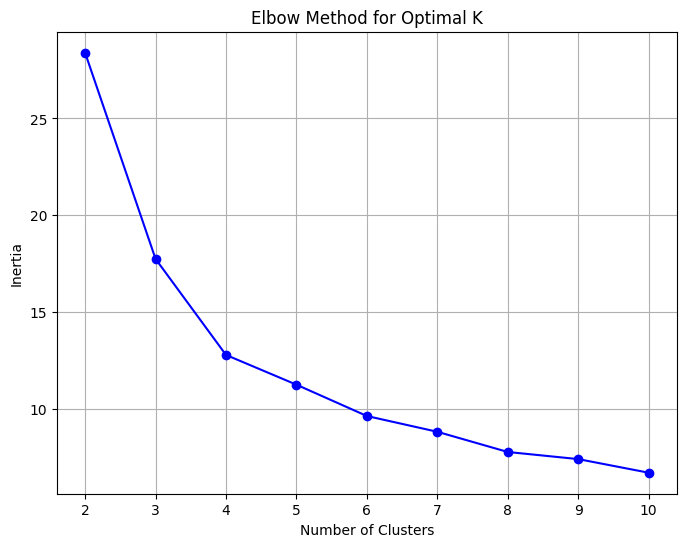

In [5]:
# Evaluate inertia for KMeans with different cluster numbers
inertia = []
k_range = range(2, 11)  # Clustering with 2 to 10 clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o', color='b')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid()
plt.show()


Apply Clustering with Optimal K

In [6]:
# Choose the optimal number of clusters based on the elbow curve
optimal_k = 4  # For example, assume the elbow is at k=4

# Perform KMeans clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_profile['Cluster'] = kmeans.fit_predict(normalized_features)

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(normalized_features, customer_profile['Cluster'])
print(f"Davies-Bouldin Index: {db_index:.2f}")


Davies-Bouldin Index: 0.89


Step 3: Visualization of Clusters
Visualize Clusters with Pairplot

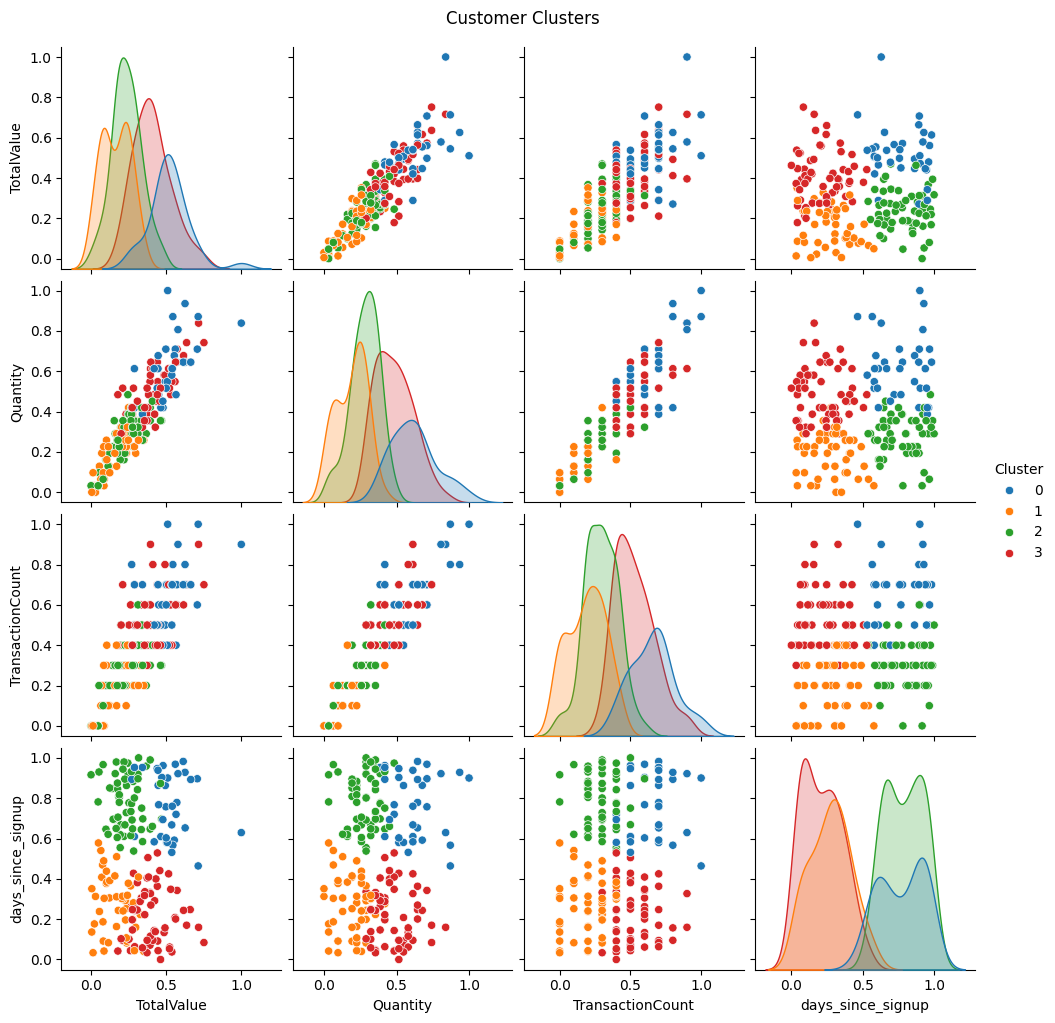

In [7]:
# Add cluster labels to the normalized features for visualization
normalized_features_df = pd.DataFrame(normalized_features, columns=features.columns)
normalized_features_df['Cluster'] = customer_profile['Cluster']

# Pairplot to visualize clusters
sns.pairplot(normalized_features_df, hue='Cluster', palette='tab10', diag_kind='kde')
plt.suptitle('Customer Clusters', y=1.02)
plt.show()


Visualize Clusters by Spending and Quantity

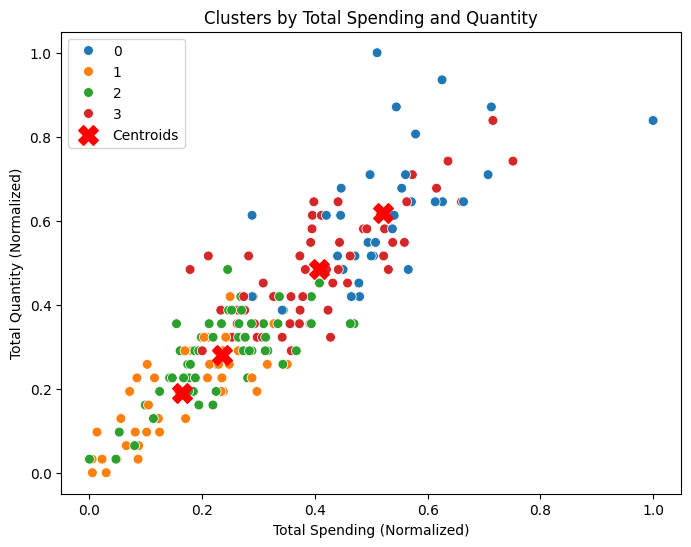

In [8]:
# Cluster centroids visualization
centroids = kmeans.cluster_centers_

# Scatter plot of clusters by spending and quantity
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=normalized_features_df['TotalValue'],
    y=normalized_features_df['Quantity'],
    hue=normalized_features_df['Cluster'],
    palette='tab10',
    s=50
)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroids')
plt.title('Clusters by Total Spending and Quantity')
plt.xlabel('Total Spending (Normalized)')
plt.ylabel('Total Quantity (Normalized)')
plt.legend()
plt.show()


Cluster Descriptions:

    Cluster 0: Customers with high spending and frequent purchases.
    Cluster 1: Customers with moderate spending and quantity.
    Cluster 2: Customers with low spending and few transactions.
    Cluster 3: New customers with minimal purchase history.

Business Implications
High-Spending Customers:

    Cluster 0 customers are valuable for premium product offerings and loyalty programs.
Moderate Customers:

    Clusters 1 and 2 represent customers who might respond well to targeted discounts or upselling.
Low-Spending Customers:

    Cluster 3 could benefit from re-engagement strategies, such as special promotions or personalized recommendations.

Recommendations
Tailored Marketing:

Segment-specific campaigns can drive engagement and maximize ROI.
High-value customers (Cluster 0) deserve focused retention efforts.
Customer Growth:

Moderate customers (Clusters 1 and 2) should be encouraged to increase spending.
New customers (Cluster 3) require nurturing for loyalty building.
Data-Driven Decisions:

Regular clustering updates will help adapt strategies as customer behavior evolves.